<a href="https://colab.research.google.com/github/adewale-codes/computer_vision_practice/blob/main/Gabor_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2D Gabor filter with matplotlib

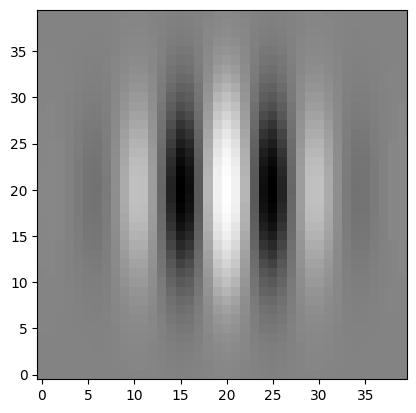

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

f = 0.1
theta = math.radians(0.0) # Converts angle x from degrees to radians.
sigma_x = 7.0
sigma_y = 7.0
radius = 20

M = np.zeros((radius*2,radius*2))

def ChangeBase(x,y,theta):
    x_theta = x * math.cos(theta) + y * math.sin(theta)
    y_theta = y * math.cos(theta) - x * math.sin(theta)
    return x_theta, y_theta

def GaborFunction(x,y,theta,f,sigma_x,sigma_y):
    r1 = ChangeBase(x,y,theta)[0] / sigma_x
    r2 = ChangeBase(x,y,theta)[1] / sigma_y
    arg = - 0.5 * ( r1**2 + r2**2 )
    return math.exp(arg) * math.cos(2*math.pi*f*ChangeBase(x,y,theta)[0])

x = -float(radius)
for i in range(radius*2):
    y = -float(radius)
    for j in range(radius*2):
        M[i,j] = GaborFunction(x,y,theta,f,sigma_x,sigma_y)
        y = y + 1
    x = x + 1

#print M.max(), M.min()
# Normalization from 0 to 255
M[:,:] = ( (M[:,:] - M.min() ) * 255 ) / ( M.max() - M.min() )
#print M.max(), M.min()

plt.imshow(M.T, cmap = cm.Greys_r, origin='lower')

#plt.imshow(M.T, origin='lower')
#plt.colorbar()

plt.savefig('GaborFilter.png')
plt.show()

3D Gabor filter with matplotlib

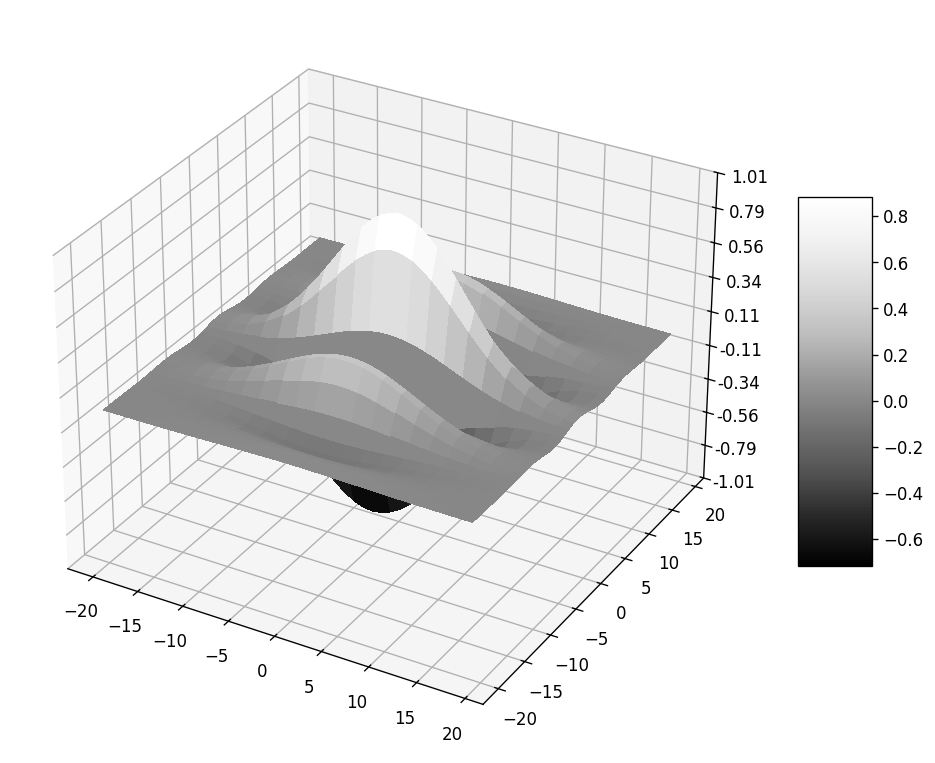

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
import math

f = 0.1
theta = math.radians(0.0) # Converts angle x from degrees to radians.
sigma_x = 7.0
sigma_y = 7.0
radius = 20

M = np.zeros((radius*2,radius*2))

def ChangeBase(x,y,theta):
    x_theta = x * math.cos(theta) + y * math.sin(theta)
    y_theta = y * math.cos(theta) - x * math.sin(theta)
    return x_theta, y_theta

def GaborFunction(x,y,theta,f,sigma_x,sigma_y):
    r1 = ChangeBase(x,y,theta)[0] / sigma_x
    r2 = ChangeBase(x,y,theta)[1] / sigma_y
    arg = - 0.5 * ( r1**2 + r2**2 )
    return math.exp(arg) * math.cos(2*math.pi*f*ChangeBase(x,y,theta)[0])

x = -float(radius)
for i in range(radius*2):
    y = -float(radius)
    for j in range(radius*2):
        M[i,j] = GaborFunction(x,y,theta,f,sigma_x,sigma_y)
        y = y + 1
    x = x + 1

fig = plt.figure(figsize=(10, 8), dpi=120)
ax = fig.add_subplot(111, projection='3d')
X = np.arange(-20, 20, 1.0)
Y = np.arange(-20, 20, 1.0)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, M, rstride=1, cstride=2, cmap=cm.Greys_r,
        linewidth=1, antialiased=False)
ax.set_zlim(-1.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig('GaborFilter_3d.png')
plt.show()

##### Gabor Filter In Edge Detection

Concepts
Think of Gabor Filters as a sine wave imposed on a bell curve (Gaussian) in 2D space. In 2D space, the sine wave is directional. Meanwhile the bell curve peaks at a point and tapers off in all directions. Combining the two results in a directional wave that focuses on a point in space within a local area. We suggest searching in your favorite search engine for an image of the Gabor Filter to better visualize this. When applying this to an image, we expose several favorable properties:

It emphasizes edge pixels.
1. Pixels immediately adjacent become suppressed.
2. It is directional
3. Pixels farther away have less influence (Local area)
4. Since the filter exhibits both a sine wave and bell curve nature, parameters common to both affect our filter:

1. sigma σ – Standard Deviation – Property of our bell curve. Smaller values emphasize values closer to the center
2. theta θ – Direction – Identifies direction of our sine wave
3. lambda λ – Wavelength – Distance between peaks in our sine wave
4. gamma γ – Ellipticity – Determines how elliptic our 2D bell curve is
5. psi φ – Offset – Defines the phase offset of our sine wave

At the heart of applying Gabor Filter in edge detection is applying each filter (for each direction) to the pixels of an image. Subsequently, we superimpose each result to create a final image.

In [5]:
#Importing Libraries and OpenCV
import cv2
import numpy as np
from matplotlib import pyplot as plt

#The line below is necessary to show Matplotlib's plots inside a Jupyter Notebook
%matplotlib inline

from matplotlib import pyplot as plt

#Use this helper function if you are working in Jupyter Lab
#If not, then directly use cv2.imshow(<window name>, <image>)

def showimage(myimage, figsize=[10,10]):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

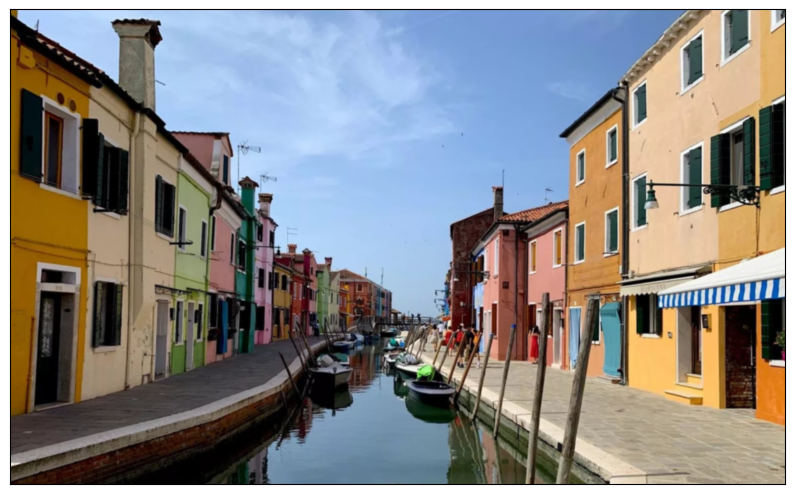

In [7]:
#At this point, we import an image for processing

myimage = cv2.imread("building.jpg")
showimage(myimage)

##### Practical application of Gabor Filter in Edge Detection
Now that we have our pre-requisites declared, we will create two functions.
1. Firstly a function to create our Gabor Filters.
2. Secondly a function to apply the filter and superimpose the results.

If you recall, the Gabor Filter has a directional element (Theta). In other words to cover edges in different directions, we need more than one Gabor Filter. Therefore we decided to create 16 filters evenly distributed around 180 degrees. This is greatly simplified using OpenCV’s built-in getGaborKernel function. Owing to this, our function returns 16 filters as a list.

In [8]:
def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree

    filters = []
    num_filters = 16
    ksize = 35  # The local area to evaluate
    sigma = 3.0  # Larger Values produce more edges
    lambd = 10.0
    gamma = 0.5
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

Correspondingly, we create a function to apply our filters.

In [9]:
def apply_filter(img, filters):
# This general function is designed to apply filters to our image

    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)

    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image

    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image

        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)
    return newimage

At this point, we have our two functions defined and we can proceed to apply this to our image.

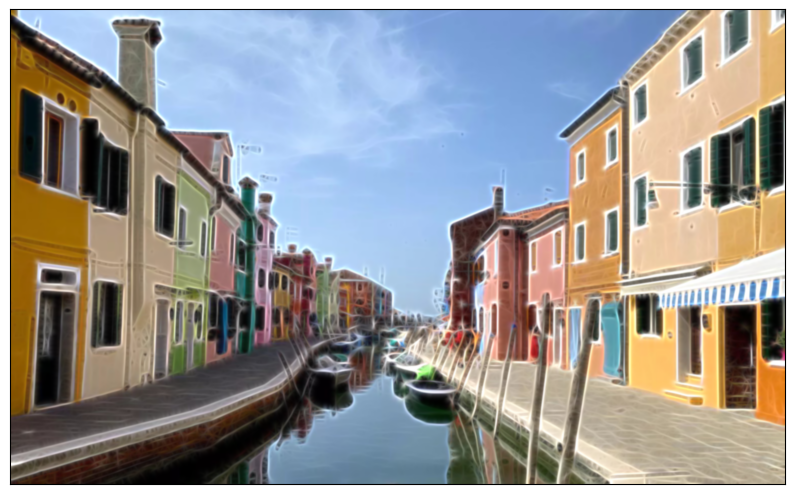

In [10]:
# We create our gabor filters, and then apply them to our image
gfilters = create_gaborfilter()
image_g = apply_filter(myimage, gfilters)

showimage(image_g)

Evidently upon closer examination, notice how edges have a “glow” to them. The edges of windows seem highlighted as well as edges of houses and the pier.

Using OpenCV’s built in Canny Edge function, we define our min and max threshold. Afterwards we feed our image into the model to obtain the results

In [11]:
# We use the built in Canny Edge function from OpenCV to find edges
# Three parameters are needed to execute the Canny Edge function
# Image, Min Threshold, Max Threshold

min_interval = 120
max_interval = 250

# Create a new image of the edges
image_edge = cv2.Canny(myimage,min_interval,max_interval)


Finally we display our results.

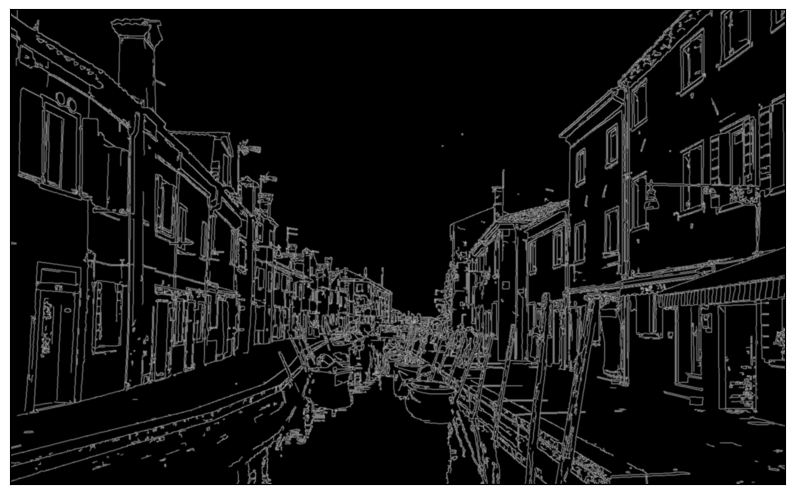

In [12]:
showimage(image_edge)

##### Applying Canny Edge Detection again
Up to the present time we have applied our Gabor Filter. Subsequently we apply Canny Edge detection on our new image. Finally we will show the result of Canny Edge detection before and after Gabor Filters.

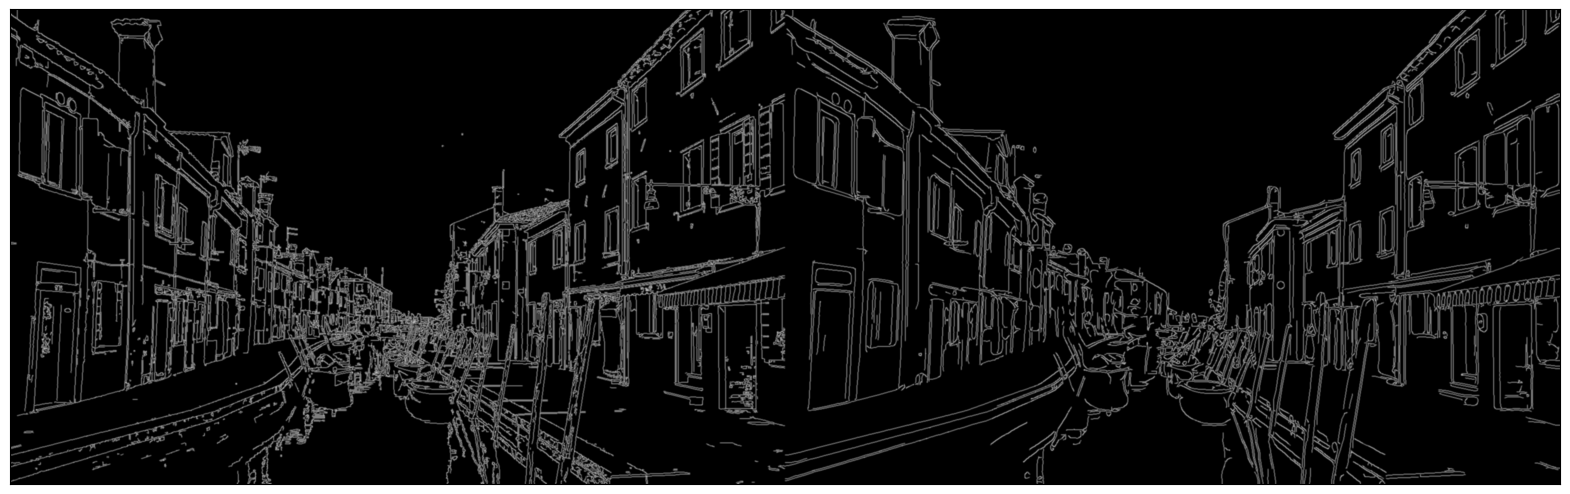

In [13]:
min_interval = 120
max_interval = 250
image_edge_g = cv2.Canny(image_g,min_interval,max_interval)


# Using Numpy's function to append the two images horizontally
side_by_side = np.hstack((image_edge,image_edge_g))
showimage(side_by_side,[20,10])

Conclusions
Comparatively, applying Gabor Filters in Edge Detection made significant improvements. By and large lines are cleaner and object edges are better detected. Explicitly, the wooden piers and building edges are better highlighted. Straightaway, by applying Gabor Filter, we achieve better results than directly applying Canny. Of course, by further tuning our parameters, we potentially can achieve even better results.

In [14]:
def extract_gabor_features(img, filters):
    features = []
    for kern in filters:
        filtered_img = cv2.filter2D(img, -1, kern)
        mean_val = filtered_img.mean()
        std_val = filtered_img.std()
        energy = np.sum(filtered_img ** 2)
        features.append([mean_val, std_val, energy])
    return np.array(features)


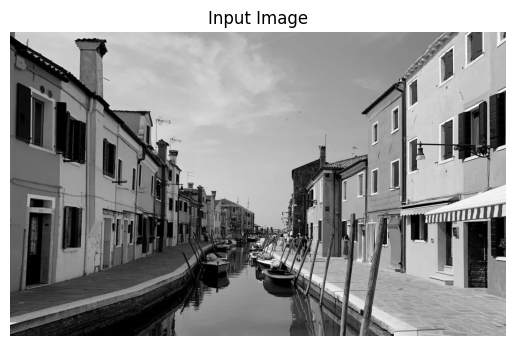

Texture Features from each filter:
 [[1.28958222e+02 6.81610937e+01 1.47261785e+08]
 [1.28809898e+02 6.77218220e+01 1.48225459e+08]
 [1.28478469e+02 6.61676415e+01 1.51612604e+08]
 [1.28299265e+02 6.46752664e+01 1.53553178e+08]
 [1.28224658e+02 6.39012711e+01 1.54097619e+08]
 [1.28228671e+02 6.37432976e+01 1.53436298e+08]
 [1.28307672e+02 6.39437624e+01 1.53446156e+08]
 [1.28405282e+02 6.42460193e+01 1.52628557e+08]
 [1.28479242e+02 6.42582641e+01 1.52294057e+08]
 [1.28496065e+02 6.39597421e+01 1.52671638e+08]
 [1.28438649e+02 6.36000739e+01 1.53512343e+08]
 [1.28421222e+02 6.33687031e+01 1.53871918e+08]
 [1.28390678e+02 6.34914704e+01 1.53937049e+08]
 [1.28371410e+02 6.41172699e+01 1.53404427e+08]
 [1.28448319e+02 6.54550070e+01 1.51956924e+08]
 [1.28708566e+02 6.71321589e+01 1.48950760e+08]]


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image (make sure it's in grayscale)
img = cv2.imread("building.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

# Create the filter bank
gabor_filters = create_gaborfilter()

# Extract texture features
features = extract_gabor_features(img, gabor_filters)
print("Texture Features from each filter:\n", features)
